In [1]:
# Install necessary dependencies
!pip install transformers pillow tensorflow datasets accelerate

import os
import cv2
import numpy as np
import json
from PIL import Image, Image as PILImage
import requests
from io import BytesIO
import tensorflow as tf
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import TrainingArguments, Trainer, default_data_collator
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# This cell is for uploading files in Google Colab.
# Upload data.json and all your image files (e.g., table0.png, table1.png, etc.).
# After uploading, ensure that data.json and images are in the correct locations:
# data.json in the current directory
# images in a folder named 'images'
from google.colab import files
uploaded = files.upload()  # Select data.json and image files

import os

# Create an images folder if not exists
if not os.path.exists('images'):
    os.mkdir('images')

# Move image files to 'images' directory if not already there
for filename in uploaded.keys():
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        os.rename(filename, os.path.join('images', filename))


Saving data.json to data.json
Saving readme.txt to readme.txt
Saving table0.png to table0.png
Saving table1.png to table1.png
Saving table2.png to table2.png
Saving table3.png to table3.png
Saving table4.png to table4.png
Saving table5.png to table5.png
Saving table6.png to table6.png
Saving table7.png to table7.png
Saving table8.png to table8.png
Saving table9.png to table9.png
Saving table10.png to table10.png
Saving table11.png to table11.png
Saving table12.png to table12.png
Saving table13.png to table13.png
Saving table14.png to table14.png
Saving table15.png to table15.png
Saving table16.png to table16.png
Saving table17.png to table17.png
Saving table18.png to table18.png
Saving table19.png to table19.png
Saving table20.png to table20.png
Saving table21.png to table21.png
Saving table22.png to table22.png
Saving table23.png to table23.png
Saving table24.png to table24.png
Saving table25.png to table25.png
Saving table26.png to table26.png
Saving table27.png to table27.png
Saving

In [3]:
import os
from PIL import Image
from datasets import load_dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AutoTokenizer
from transformers import TrainingArguments, Trainer, default_data_collator

# Load your dataset from data.json
# data.json should be in the current working directory
data_file = 'data.json'
dataset = load_dataset('json', data_files=data_file, field='data')

# Split into train/validation: 90% train, 10% validation
dataset = dataset['train'].train_test_split(test_size=0.1)
train_dataset = dataset['train']
eval_dataset = dataset['test']

# Load processor, tokenizer, and model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
tokenizer = AutoTokenizer.from_pretrained('agomberto/trocr-large-handwritten-fr')
model = VisionEncoderDecoderModel.from_pretrained('agomberto/trocr-large-handwritten-fr')

image_base_path = "./images"  # Directory where images are stored

def preprocess_data(examples):
    images = []
    for img_path in examples['path']:
        full_path = os.path.join(image_base_path, img_path)
        img = Image.open(full_path).convert("RGB")
        images.append(img)

    pixel_values = processor(images=images, return_tensors="pt").pixel_values
    labels = tokenizer(examples['trans'], padding="max_length", max_length=128, truncation=True).input_ids
    # Replace pad token ID with -100 for masked tokens
    labels = [[(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels]
    return {"pixel_values": pixel_values, "labels": labels}

train_dataset = train_dataset.map(preprocess_data, batched=True, remove_columns=['path','trans'])
eval_dataset = eval_dataset.map(preprocess_data, batched=True, remove_columns=['path','trans'])
train_dataset.set_format(type="torch", columns=["pixel_values", "labels"])
eval_dataset.set_format(type="torch", columns=["pixel_values", "labels"])

data_collator = default_data_collator


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.82k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

generation_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [4]:
# Define training arguments

training_args = TrainingArguments(
    output_dir="./trocr_finetuned",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    evaluation_strategy="steps",
    eval_steps=10,
    logging_steps=10,
    save_steps=1000,
    save_total_limit=2,
    num_train_epochs=3,
    fp16=True,
    learning_rate=5e-5,
    report_to="none"
)
'''training_args = TrainingArguments(
    output_dir="./trocr_finetuned",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=25,
    save_total_limit=2,
    num_train_epochs=10,
    fp16=True,
    learning_rate=5e-5,
    report_to="none"
)
'''
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

# Train the model

trainer.train()

# Save the fine-tuned model
trainer.save_model("./trocr_finetuned_model")
model.save_pretrained('./trocr_finetuned_model')
processor.save_pretrained('./trocr_finetuned_model')
tokenizer.save_pretrained('./trocr_finetuned_model')

import shutil

# Zip the model directory
shutil.make_archive("trocr_finetuned_model", 'zip', './trocr_finetuned_model')
files.download("trocr_finetuned_model.zip")




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
10,2.362000,2.279955
20,2.143700,2.430665
30,2.612000,2.927070
40,2.201900,2.894133
50,1.386000,3.618333
60,1.531500,3.161004
70,0.891500,2.842144
80,0.978200,2.645773
90,1.123000,2.512427
100,0.584100,2.569661


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import torch

Steps for Evaluation: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
Evaluation Loss: [2.2799551486968994, 2.4306654930114746, 2.927069902420044, 2.8941333293914795, 3.618332624435425, 3.1610043048858643, 2.842144012451172, 2.64577317237854, 2.5124270915985107, 2.5696611404418945, 2.4594757556915283, 2.352602481842041, 2.2623677253723145]
Steps for Training: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
Training Loss: [2.362, 2.1437, 2.612, 2.2019, 1.386, 1.5315, 0.8915, 0.9782, 1.123, 0.5841, 0.6543, 0.3607, 0.6277]


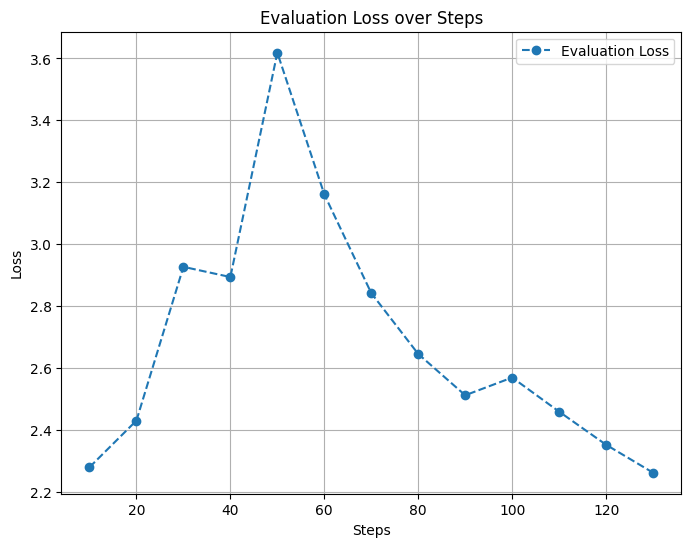

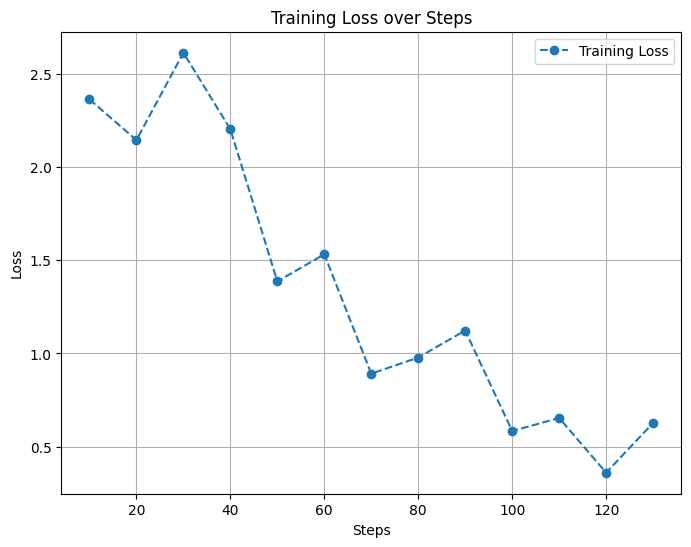

In [6]:
import matplotlib.pyplot as plt

# Extract logs from trainer's log history
logs = trainer.state.log_history

# Initialize lists to store values
steps_eval = []  # Steps at which evaluation happened
steps_train = []  # Steps for training loss
eval_loss = []
train_loss = []
cer = []

# Parse logs
for log in logs:
    if 'eval_loss' in log:
        steps_eval.append(log.get('step', None))
        eval_loss.append(log['eval_loss'])
        if 'eval_cer' in log:  # If CER is calculated
            cer.append(log['eval_cer'])
    if 'loss' in log and 'step' in log:
        steps_train.append(log['step'])
        train_loss.append(log['loss'])

# Debugging: Print lists to ensure they are populated
print("Steps for Evaluation:", steps_eval)
print("Evaluation Loss:", eval_loss)
print("Steps for Training:", steps_train)
print("Training Loss:", train_loss)

# Check if evaluation loss exists
if eval_loss:
    # Plot evaluation loss against steps
    plt.figure(figsize=(8, 6))
    plt.plot(steps_eval, eval_loss, label='Evaluation Loss', marker='o', linestyle='--')
    plt.title('Evaluation Loss over Steps')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No evaluation loss found in log history.")

# Plot training loss if available
if train_loss:
    plt.figure(figsize=(8, 6))
    plt.plot(steps_train, train_loss, label='Training Loss', marker='o', linestyle='--')
    plt.title('Training Loss over Steps')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No training loss found in log history.")


In [7]:
fine_tuned_model = VisionEncoderDecoderModel.from_pretrained("./trocr_finetuned_model")

# Example of inference on one image:
test_img_path = os.path.join('images', 'table0.png')  # Replace with the actual image file
test_img = Image.open(test_img_path).convert("RGB")
pixel_values = processor(images=test_img, return_tensors="pt").pixel_values
generated_ids = fine_tuned_model.generate(pixel_values)
text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Recognized text:", text)


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

Recognized text: Barne hile 14 janvier 88


In [8]:
# import Line Segmenter Class

import cv2
import os
import numpy as np


class RowSegmenter:
    def __init__(self, output_folder, debug=True):

        self.output_folder = output_folder
        self.debug = debug
        os.makedirs(self.output_folder, exist_ok=True)

    def preprocess_image(self, image_path):

        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image at {image_path} could not be loaded. Check the file path.")

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        if self.debug:
            debug_binary_path = os.path.join(self.output_folder, "debug_binary.png")
            cv2.imwrite(debug_binary_path, binary)
            print(f"Binary threshold image saved for debugging: {debug_binary_path}")

        return img, binary

    def segment_rows(self, binary, original_image, padding=5):

        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        row_contours = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if 10 < h < 300:
                row_contours.append((x, y, w, h))

        row_contours.sort(key=lambda c: c[1])

        row_images = []
        last_y_end = -1
        for idx, (x, y, w, h) in enumerate(row_contours):
            if y < last_y_end:
                continue

            y_start = max(0, y - padding)
            y_end = min(original_image.shape[0], y + h + padding)
            row_image = original_image[y_start:y_end, :]
            row_images.append((row_image, (x, y, w, h)))

            row_path = os.path.join(self.output_folder, f"row_{idx + 1}.png")
            cv2.imwrite(row_path, row_image)
            print(f"Saved row image: {row_path}")

            last_y_end = y_end

        if not row_images:
            print("No rows detected. Ensure the input image is clear and properly preprocessed.")

        return row_images, row_contours

    def debug_draw_row_boundaries(self, image, row_contours, padding=5):

        debug_img = image.copy()
        for (x, y, w, h) in row_contours:
            y_start = max(0, y - padding)
            y_end = min(image.shape[0], y + h + padding)
            cv2.rectangle(debug_img, (0, y_start), (image.shape[1], y_end), (0, 255, 0), 2)

        debug_img_path = os.path.join(self.output_folder, "debug_rows.png")
        cv2.imwrite(debug_img_path, debug_img)
        print(f"Debug image with row boundaries saved: {debug_img_path}")

    def process_image(self, image_path, padding=5):

        print("Loading and preprocessing the image...")
        original_image, binary_image = self.preprocess_image(image_path)

        print("Detecting and segmenting rows...")
        row_images_and_contours, row_contours = self.segment_rows(binary_image, original_image, padding)

        if not row_images_and_contours:
            print("No rows detected. Check debug outputs.")
            return []

        if self.debug:
            print("Creating debug visualization...")
            self.debug_draw_row_boundaries(original_image, row_contours)

        print(f"Row segments saved in: {self.output_folder}")
        return row_images_and_contours


Saving image.png to image.png
Loading and preprocessing the image...
Binary threshold image saved for debugging: /content/row_segments/debug_binary.png
Detecting and segmenting rows...
Saved row image: /content/row_segments/row_1.png
Saved row image: /content/row_segments/row_15.png
Saved row image: /content/row_segments/row_29.png
Saved row image: /content/row_segments/row_42.png
Saved row image: /content/row_segments/row_61.png
Saved row image: /content/row_segments/row_72.png
Saved row image: /content/row_segments/row_76.png
Saved row image: /content/row_segments/row_86.png
Saved row image: /content/row_segments/row_105.png
Saved row image: /content/row_segments/row_119.png
Saved row image: /content/row_segments/row_130.png
Saved row image: /content/row_segments/row_149.png
Saved row image: /content/row_segments/row_158.png
Saved row image: /content/row_segments/row_165.png
Saved row image: /content/row_segments/row_177.png
Saved row image: /content/row_segments/row_180.png
Saved ro

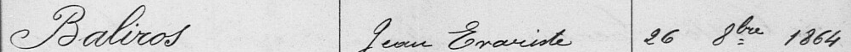

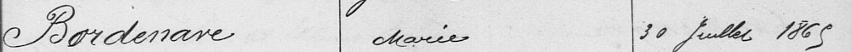

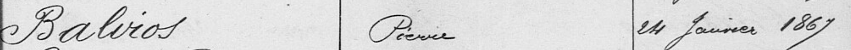

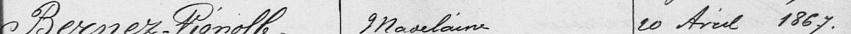

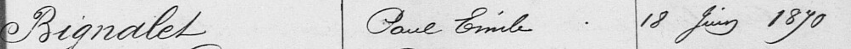

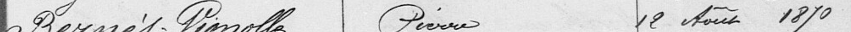

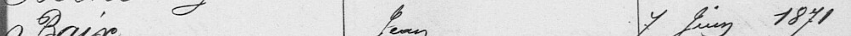

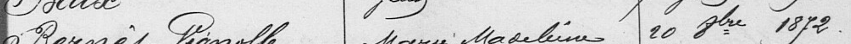

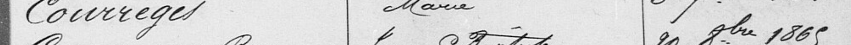

In [13]:
# Set up the segmenter
# gets input from user for file
# Gives segmented images for the model
output_folder = "/content/row_segments"
segmenter = RowSegmenter(output_folder)
!rm -rf /content/row_segments/*

from google.colab import files
image_file_actual = files.upload()
image_path = list(image_file_actual.keys())[0]

segmented_rows = segmenter.process_image(image_path)


from IPython.display import Image, display
import os
row_image_files = sorted(
    [f for f in os.listdir(output_folder) if f.startswith("row_") and f.endswith(".png")],
    key=lambda x: int(x.split('_')[1].split('.')[0])
)
for row_image_file in row_image_files:
    row_image_path = os.path.join(output_folder, row_image_file)
    display(Image(filename=row_image_path))

In [14]:
# Fetch the image data from the /contents/row_segments
import os
from PIL import Image as PILImage
row_image_files = sorted(
    [f for f in os.listdir(output_folder) if f.startswith("row_") and f.endswith(".png")],
    key=lambda x: int(x.split('_')[1].split('.')[0])  # Sort by numeric order in filenames
)

# Load images using PIL
img_list = []
for row_image_file in row_image_files:
    row_image_path = os.path.join(output_folder, row_image_file)
    image = PILImage.open(row_image_path)
    img_list.append(image)

print(f"Loaded {len(img_list)} segmented images.")

Loaded 19 segmented images.


In [15]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, AutoTokenizer

# Load the model, processor, and tokenizer
model_dir = "./trocr_finetuned_model"
model = VisionEncoderDecoderModel.from_pretrained(model_dir)
processor = TrOCRProcessor.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

In [16]:
generated_text = []  # To store recognized text

for idx, image in enumerate(img_list):
    # Prepare image for the model
    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    # Generate text from image
    generated_ids = model.generate(pixel_values)
    text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Save the result
    generated_text.append(text)
    print(f"Line {idx + 1}: {text}")

Line 1: Baliros Jean Evacile 26 8bre 1864
Line 2: Bordenere Marie 10 juillet 1865
Line 3: Baliros Pierre 24 fevrier 1867
Line 4: Bernet-Penolle Maoulaine 20 avril 1867
Line 5: Dlèse 18co
Line 6: Bernet Marcelle Françoise 9 9bre 1881
Line 7: 976 Déphbre 1868
Line 8: Bignalet Paule 18 juin 1890
Line 9: Pournès Pierre Pierre 12 aout 1850
Line 10: Bournon Pierre 7 juin 1851
Line 11: Dommèelle Marie Maréline 20 8bre 1872
Line 12: Sémes Louise 17 9bre 1862
Line 13: Courcqes Dominique 17 9bre
Line 14: A 1 1 fevrier 21 juillet 1864
Line 15: Carenave-Poulisseon Jean Romour 1
Line 16: 9bre 1864
Line 17: Courrège 4 9bre 1865
Line 18: Ca Renase Françoise Jean Baptiste 18 8
Line 19: Bertevard Pierre 26 mai 166


In [17]:
print("\nFinal Recognized Text:")
for idx, text in enumerate(generated_text):
    print(f"Line {idx + 1}: {text}")



Final Recognized Text:
Line 1: Baliros Jean Evacile 26 8bre 1864
Line 2: Bordenere Marie 10 juillet 1865
Line 3: Baliros Pierre 24 fevrier 1867
Line 4: Bernet-Penolle Maoulaine 20 avril 1867
Line 5: Dlèse 18co
Line 6: Bernet Marcelle Françoise 9 9bre 1881
Line 7: 976 Déphbre 1868
Line 8: Bignalet Paule 18 juin 1890
Line 9: Pournès Pierre Pierre 12 aout 1850
Line 10: Bournon Pierre 7 juin 1851
Line 11: Dommèelle Marie Maréline 20 8bre 1872
Line 12: Sémes Louise 17 9bre 1862
Line 13: Courcqes Dominique 17 9bre
Line 14: A 1 1 fevrier 21 juillet 1864
Line 15: Carenave-Poulisseon Jean Romour 1
Line 16: 9bre 1864
Line 17: Courrège 4 9bre 1865
Line 18: Ca Renase Françoise Jean Baptiste 18 8
Line 19: Bertevard Pierre 26 mai 166
